In [ ]:
import pprint
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # comment out if we want raw matplotlib only
import os
from collections import Counter

In [18]:
def load_metadata(file_path):
    """
    Reads a JSON file and flattens it into a DataFrame.

    Args:
        file_path (str): Path to the JSON file.

    Returns:
        pd.DataFrame: Processed metadata DataFrame.
    """
    with open(file_path, "r") as f:
        data = json.load(f)

    records = []
    for record_id, record in data.items():
        attributes = record.get('attributes', {})
        attributes['id'] = record_id  # Include ID as a column
        records.append(attributes)

    return pd.DataFrame(records)
file_path = "/projectnb/sparkgrp/ml-bpl-rag-data/full_data/bpl_meta.json"
df = load_metadata(file_path)


In [13]:
print("\nDataset Overview:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1304242 entries, 0 to 1304241
Columns: 138 entries, id to frequency_tsi
dtypes: float64(1), int64(1), object(136)
memory usage: 1.3+ GB
None

First 5 rows:
                           id    system_create_dtsi  system_modified_dtsi  \
0  commonwealth-oai:n5842629x  2023-09-07T04:34:04Z  2024-05-31T03:21:27Z   
1  commonwealth-oai:ft84d3073  2023-09-07T05:03:38Z  2024-05-31T03:29:29Z   
2      commonwealth:ms35v4434  2015-06-29T15:35:22Z  2023-11-03T18:53:53Z   
3      commonwealth:6d570801f  2014-11-18T16:26:12Z  2021-10-09T10:14:50Z   
4  commonwealth-oai:ks65nx01m  2024-03-27T03:56:01Z  2024-03-27T03:56:20Z   

        curator_model_ssi curator_model_suffix_ssi  \
0  Curator::DigitalObject            DigitalObject   
1  Curator::DigitalObject            DigitalObject   
2  Curator::DigitalObject            DigitalObject   
3  Curator::DigitalObject            DigitalObject   
4  Curator::DigitalObject            Digit

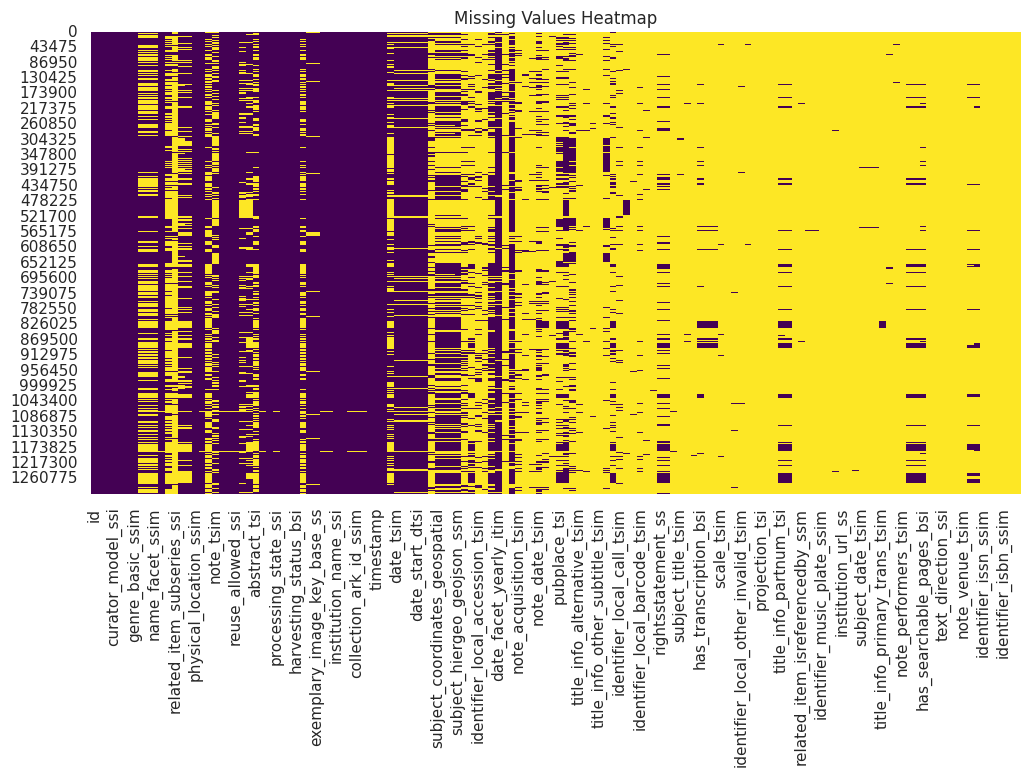

In [14]:
# Visualize missing values in the dataset
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


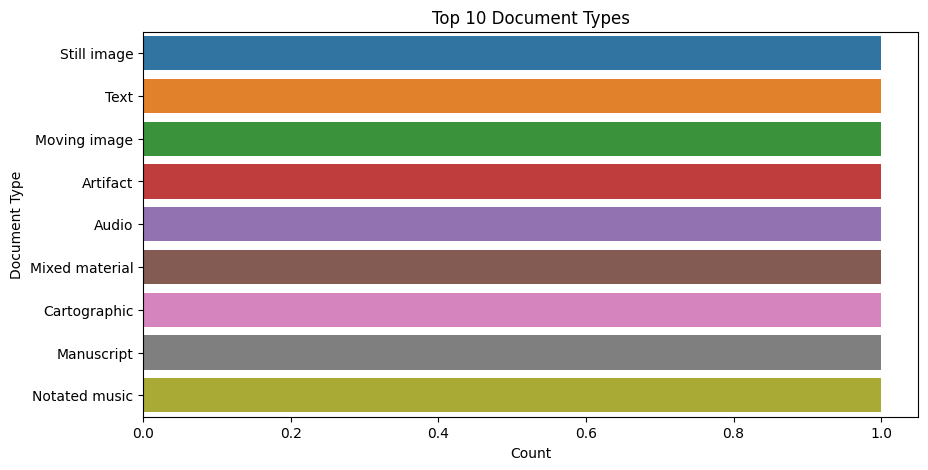

In [5]:
# Plot the distribution of the top 10 document types
if 'type_of_resource_ssim' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=df['type_of_resource_ssim'].explode().value_counts().index[:10], 
                  order=df['type_of_resource_ssim'].explode().value_counts().index[:10])
    plt.title("Top 10 Document Types")
    plt.xlabel("Count")
    plt.ylabel("Document Type")
    plt.show()


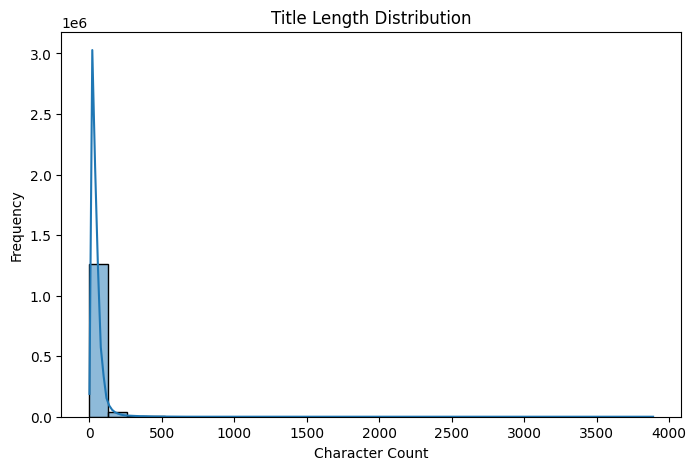

In [6]:
# Plot the distribution of title lengths
if 'title_info_primary_tsi' in df.columns:
    df['title_length'] = df['title_info_primary_tsi'].astype(str).apply(len)
    plt.figure(figsize=(8, 5))
    sns.histplot(df['title_length'], bins=30, kde=True)
    plt.title("Title Length Distribution")
    plt.xlabel("Character Count")
    plt.ylabel("Frequency")
    plt.show()


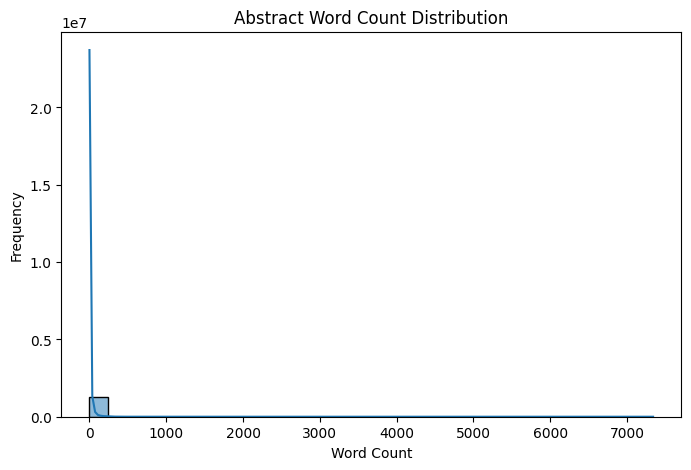

In [7]:
# Plot the distribution of abstract word counts
if 'abstract_tsi' in df.columns:
    df['abstract_length'] = df['abstract_tsi'].astype(str).apply(lambda x: len(x.split()))
    plt.figure(figsize=(8, 5))
    sns.histplot(df['abstract_length'], bins=30, kde=True)
    plt.title("Abstract Word Count Distribution")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.show()


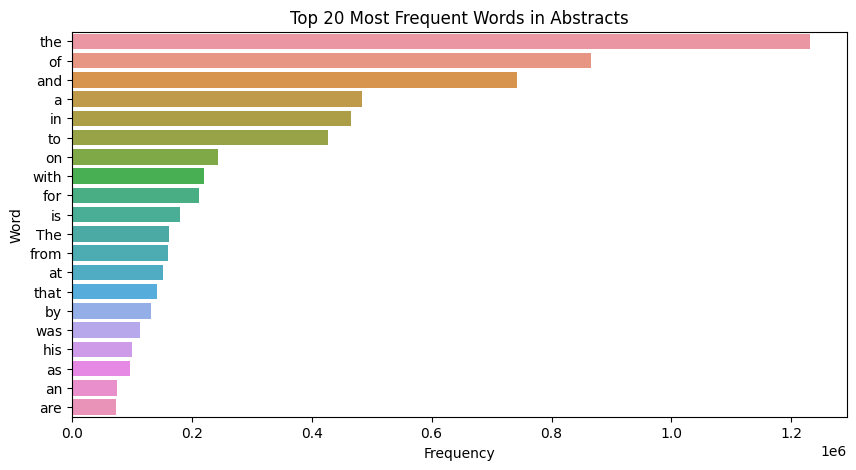

In [8]:
# Displaying the most common words in abstracts
if 'abstract_tsi' in df.columns:
    word_list = " ".join(df['abstract_tsi'].dropna()).split()
    common_words = Counter(word_list).most_common(20)
    
    words, counts = zip(*common_words)
    
    # Convert tuples to lists
    words = list(words)
    counts = list(counts)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=counts, y=words)
    plt.title("Top 20 Most Frequent Words in Abstracts")
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.show()

/scratch/2945023.1.w/ipykernel_1802418/1419034166.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(top_fields.index, rotation=45, ha='right')


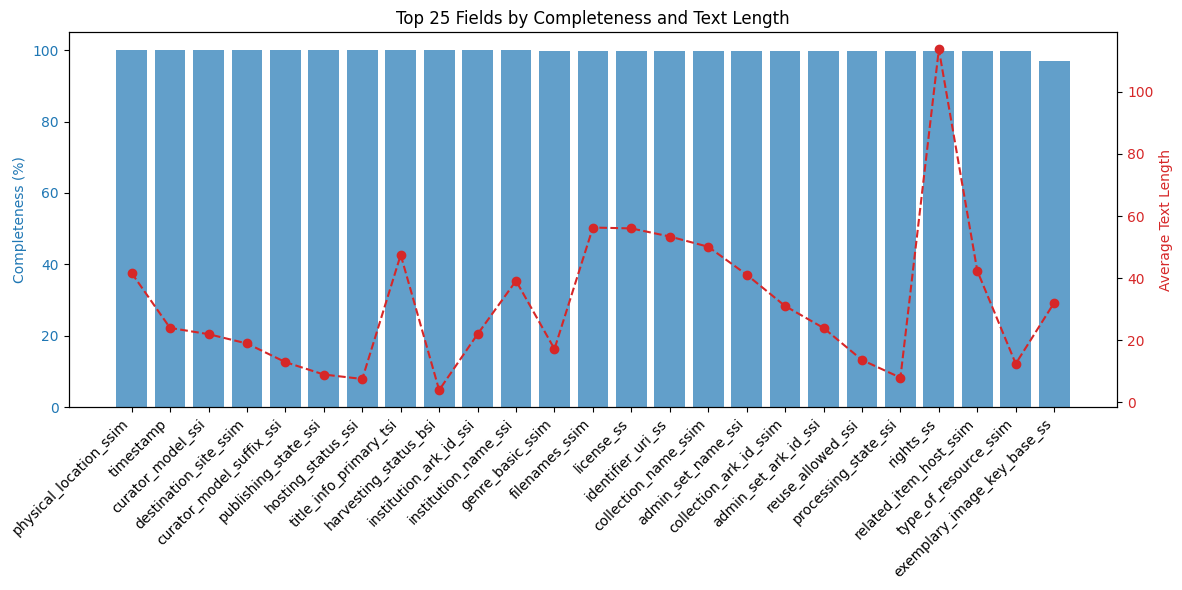

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Exclude system-level and technical fields if they don't matter for search
ignore_fields = ['id', 'system_create_dtsi', 'system_modified_dtsi']

# Completeness — % of non-null entries per column
completeness = df.drop(columns=ignore_fields, errors='ignore').notnull().mean()

# Text Length — Average length of text in each column
text_lengths = {}
for col in df.columns:
    if df[col].dtype == 'object' and col not in ignore_fields:
        text_lengths[col] = df[col].dropna().astype(str).apply(len).mean()

text_lengths = pd.Series(text_lengths)

# Combine into DataFrame
field_quality = pd.DataFrame({
    'Completeness': completeness,
    'Average Text Length': text_lengths
}).dropna().sort_values(['Completeness', 'Average Text Length'], ascending=[False, False])

# Filter top 25 fields
top_fields = field_quality.head(25)

# Plot Completeness and Text Length
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.bar(top_fields.index, top_fields['Completeness'] * 100, color=color, alpha=0.7)
ax1.set_ylabel('Completeness (%)', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(top_fields.index, rotation=45, ha='right')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(top_fields.index, top_fields['Average Text Length'], color=color, marker='o', linestyle='--')
ax2.set_ylabel('Average Text Length', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Top 25 Fields by Completeness and Text Length')
plt.tight_layout()
plt.show()


The most complete fields are system-level metadata like physical_location_ssim and timestamp, which are reliable but not very useful for search. Key descriptive fields like title_info_primary_tsi have good completeness and reasonable length, making them strong candidates for retrieval. In contrast, fields like rights_ssi and related_item_host_ssim show inconsistent lengths, reflecting uneven metadata quality. Overall, descriptive metadata is often shorter than ideal, which may limit search relevance if not addressed in preprocessing.

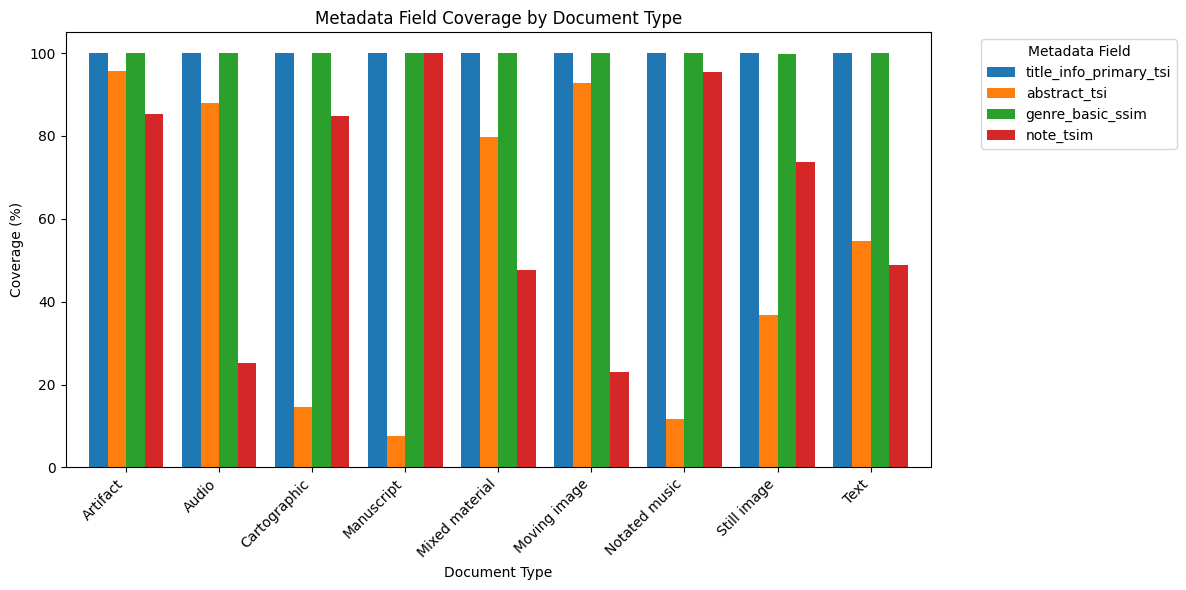

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure type_of_resource_ssim exists
if 'type_of_resource_ssim' not in df.columns:
    raise ValueError("Column 'type_of_resource_ssim' is missing from the DataFrame. This analysis depends on it.")

# Expand list column if needed
df_exploded = df.explode('type_of_resource_ssim')

# Define key fields (but filter out any that are missing)
key_fields = [
    'title_info_primary_tsi',
    'abstract_tsi',
    'subject_tsim',
    'genre_basic_ssim',
    'note_tsim'
]

available_fields = [col for col in key_fields if col in df.columns]

if not available_fields:
    raise ValueError("None of the expected key fields are present in the DataFrame.")

# Completeness calculation by document type
coverage = df_exploded.groupby('type_of_resource_ssim')[available_fields].apply(lambda g: g.notnull().mean() * 100)

# Plot
coverage.plot(kind='bar', figsize=(12, 6), width=0.8)

plt.title('Metadata Field Coverage by Document Type')
plt.ylabel('Coverage (%)')
plt.xlabel('Document Type')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metadata Field', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


Metadata coverage varies significantly across document types. Titles and genres are consistently present across all types, making them reliable fields for filtering and retrieval. However, abstracts and notes show much more variability. Text-based items like manuscripts and text documents have strong abstract coverage, while cartographic and notated music items often lack abstracts entirely. Notes are particularly sparse for cartographic and notated music items, indicating uneven descriptive metadata practices for certain formats. This imbalance means that search relevance could be biased toward text-heavy materials unless additional content is generated for under-described formats like images and maps.

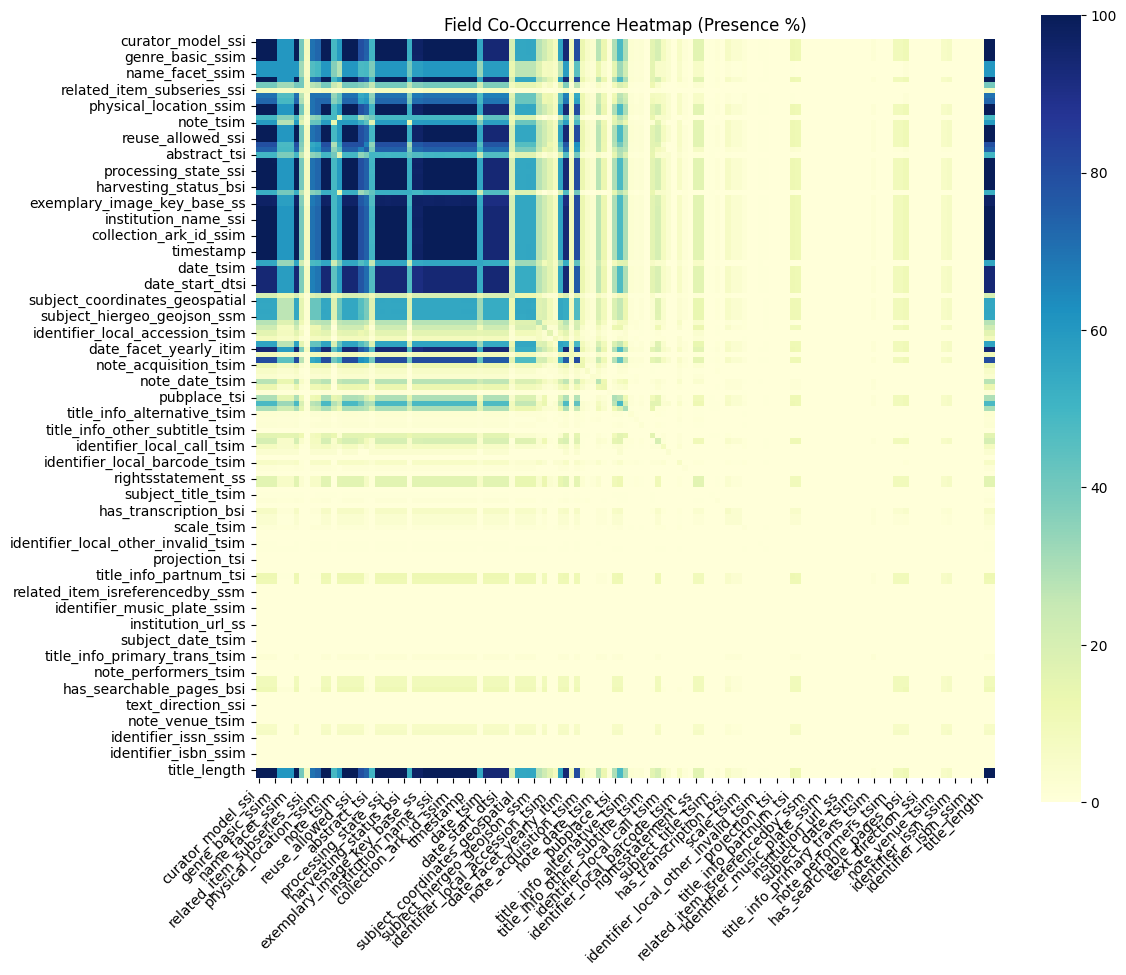

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Drop system and technical fields to focus on descriptive content
ignore_fields = ['id', 'system_create_dtsi', 'system_modified_dtsi']

descriptive_fields = [col for col in df.columns if col not in ignore_fields]

# Create a DataFrame that is True/False for presence/absence of each field
field_presence = df[descriptive_fields].notnull().astype(int)

# Calculate co-occurrence matrix (percentage of records where both fields are present)
co_occurrence = field_presence.T.dot(field_presence) / len(df) * 100

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, cmap="YlGnBu", annot=False, square=True)
plt.title("Field Co-Occurrence Heatmap (Presence %)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The heatmap shows that some fields tend to show up together a lot, especially basic system information like curator model and physical location. Important fields like titles and abstracts also often appear together, which is helpful for search. On the other hand, some fields, like notes or geospatial data, rarely appear at the same time as others. This means certain types of information are only filled in for some records, not all. To make search work well, we may need to rely on fields like titles and genres more often, especially when things like abstracts or notes are missing.

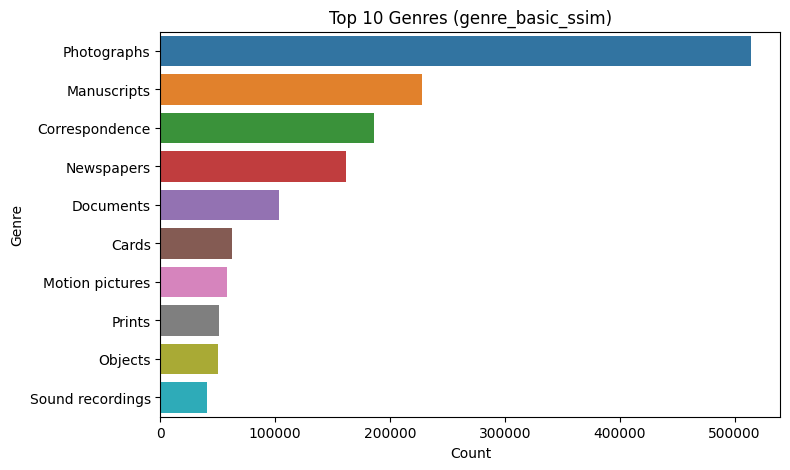

In [19]:
# 1. Distribution of genre_basic_ssim (top 10)
if "genre_basic_ssim" in df.columns:
    df_exploded_genre = df.explode("genre_basic_ssim")
    genre_counts = df_exploded_genre["genre_basic_ssim"].value_counts().head(10)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=genre_counts.values, y=genre_counts.index)
    plt.title("Top 10 Genres (genre_basic_ssim)")
    plt.xlabel("Count")
    plt.ylabel("Genre")
    plt.show()
else:
    print("Column 'genre_basic_ssim' not found, skipping genre plot.")

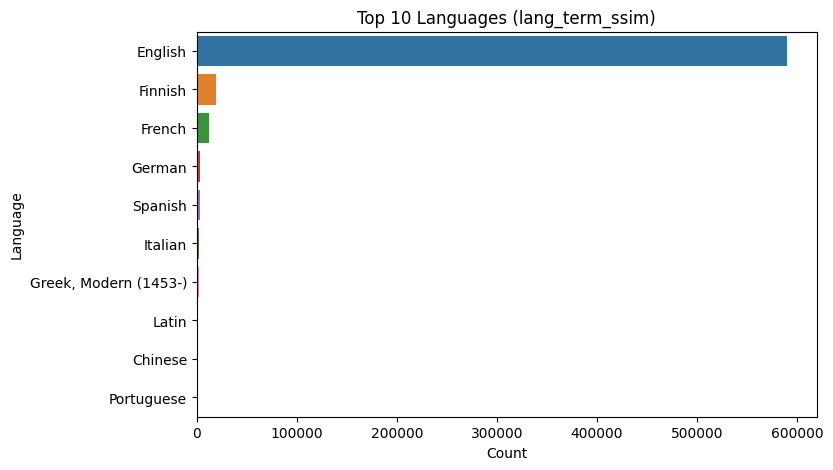

In [20]:
# 2. Language distribution (lang_term_ssim), top 10
if "lang_term_ssim" in df.columns:
    df_exploded_lang = df.explode("lang_term_ssim")
    lang_counts = df_exploded_lang["lang_term_ssim"].value_counts().head(10)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=lang_counts.values, y=lang_counts.index)
    plt.title("Top 10 Languages (lang_term_ssim)")
    plt.xlabel("Count")
    plt.ylabel("Language")
    plt.show()
else:
    print("Column 'lang_term_ssim' not found, skipping language plot.")

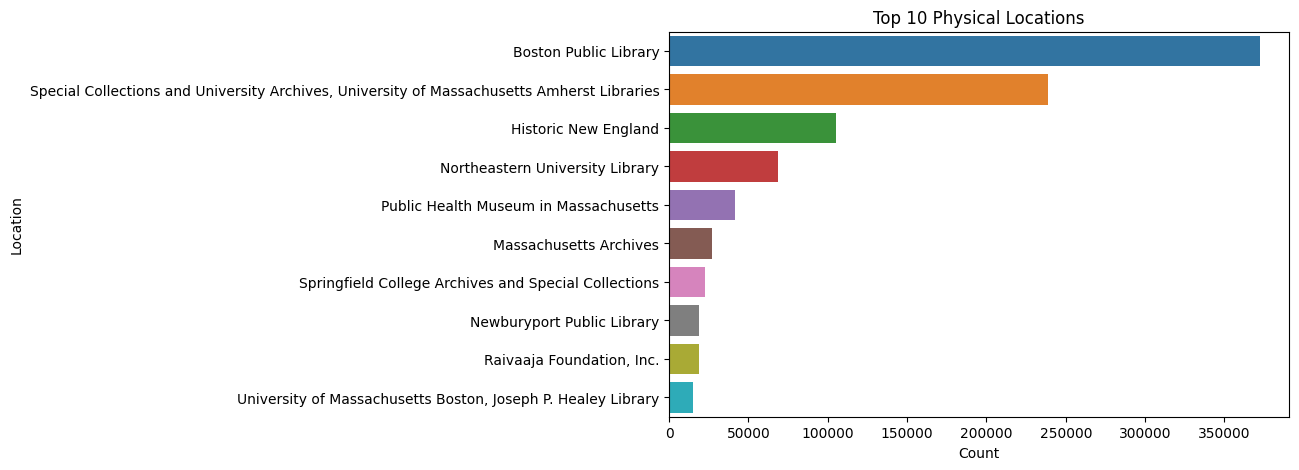

In [21]:
# 3. Physical location distribution (physical_location_ssim), top 10
if "physical_location_ssim" in df.columns:
    df_exploded_loc = df.explode("physical_location_ssim")
    loc_counts = df_exploded_loc["physical_location_ssim"].value_counts().head(10)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=loc_counts.values, y=loc_counts.index)
    plt.title("Top 10 Physical Locations")
    plt.xlabel("Count")
    plt.ylabel("Location")
    plt.show()
else:
    print("Column 'physical_location_ssim' not found, skipping location plot.")

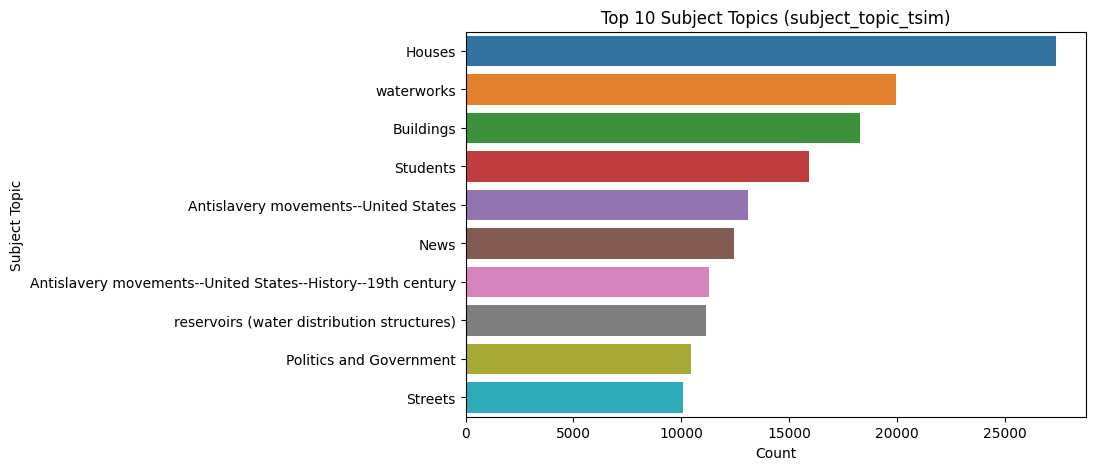

In [22]:
# 4. Subject topic distribution (subject_topic_tsim), top 10
if "subject_topic_tsim" in df.columns:
    df_exploded_subj = df.explode("subject_topic_tsim")
    subj_counts = df_exploded_subj["subject_topic_tsim"].value_counts().head(10)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=subj_counts.values, y=subj_counts.index)
    plt.title("Top 10 Subject Topics (subject_topic_tsim)")
    plt.xlabel("Count")
    plt.ylabel("Subject Topic")
    plt.show()
else:
    print("Column 'subject_topic_tsim' not found, skipping subject topic plot.")

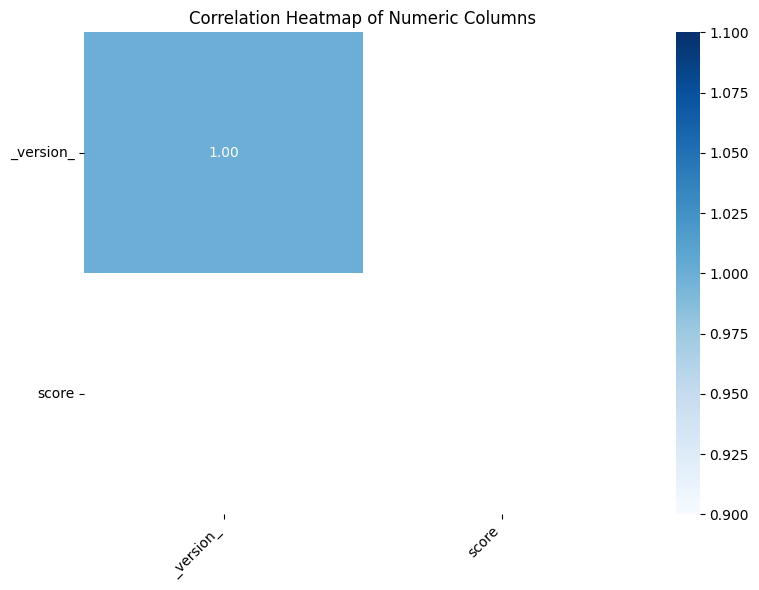

In [23]:
# 5. If we have numeric columns (besides the artificially created ones),
#    we can do a quick correlation heatmap. For example:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Filter out the ones you created, if you wish
maybe_ignore = ["title_length", "abstract_length"]
numeric_cols = [c for c in numeric_cols if c not in maybe_ignore]

if len(numeric_cols) > 1:
    corr_matrix = df[numeric_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f")
    plt.title("Correlation Heatmap of Numeric Columns")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("No multiple numeric columns to correlate, skipping correlation heatmap.")

In [ ]:
df.to_csv("cleaned_bpl_metadata.csv", index=False)
print("Cleaned dataset saved successfully.")